<center><img src="https://github.com/FASSt-simulation/fasst_simulation_tools/raw/main/images/site-logo.png" width=150 height=150 alt="NGEE-Arctic Logo"/></center>

# Tutorial: *Evaluating ELM fluxes using remote sensing imagery from Google Earth Engine*
This tutorial explores the radiation components of ELM simulations at one of the four [NGEE-Arctic](https://ngee-arctic.ornl.gov/) study sites.


#### ----------------------------------------------------------------------------------------------------------------------

<br>

#### To run this script and generate the resulting ELM plots we need specific Python libraries.  This step loads those required libraries

In [9]:
# setup modules
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import xarray
from netCDF4 import Dataset 
import os
import cftime
from datetime import datetime as dt
import ipywidgets as widgets
import sys,os,os.path,glob,numpy # or should we just do a as np?

# spatial modules
import ee
import geemap.colormaps as cm
import geemap.foliumap as geemap
    
import warnings
warnings.filterwarnings('ignore') #don't display warnings

<br>

#### This step creates a temporary folder location to store figures that are created in this notebook.  You can later download these figures to your host computer

In [7]:
## setup output. defined dir or system temp dir
output_dir=os.path.expanduser(os.path.join('~','work/figures'))

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(" ")
print("****** Temporary Output Folder ******")
print(output_dir)

 
****** Temporary Output Folder ******
/home/jovyan/work/figures


<br>

#### To use the GEE layers you need to have a GEE account and authenticate your API before proceeding

In [8]:
##### initialize ee API  - you need to authenticate with GEE and initialize

## Trigger the authentication flow. You only need to do this once while running notebook
ee.Authenticate()

## After inserting the API key initialize GEE
ee.Initialize()

# temporary api key: 4/1ARtbsJq6coZIklzx1pJggbDZrLGXXnKrcD922JqUMhOZb1YXFV2hksf8p5g

Enter verification code:  4/1ARtbsJq6coZIklzx1pJggbDZrLGXXnKrcD922JqUMhOZb1YXFV2hksf8p5g



Successfully saved authorization token.


In [10]:
# Create case run output directories

output_rootdir=os.path.expanduser('~')+'/output/cime_run_dirs/'
cases=numpy.asarray(glob.glob("%s*20TR*" % output_rootdir))
cases=[x.split('/')[-1] for x in cases]
cases_dropdown = widgets.Dropdown(options=cases,
                                description='Chose Case Name:',
                                style={'description_width':'auto'},
                                layout={'width':'max-content'},
                                disabled=False)

<br>

#### Here we create the dropdown menu of ELM output options availible in your output volume

In [11]:
# Show a dropdown menu to select specific case output
# Any cases that have been run in our elmoutput directory will be displayed
# Case names will contain the site codes:
# AK-BEO; AK-CLG; AK-K64G AK-TLG

display(cases_dropdown)

Dropdown(description='Chose Case Name:', layout=Layout(width='max-content'), options=('OLMT_AK-BEOG_ICB20TRCNP…

<br>

#### After selecting which ELM output folder we want to use as our source for simulation output, we can then find all .nc files in the output location

In [12]:
# Get the output nc file options

output_casedir=output_rootdir+cases_dropdown.value+'/run/'
filenames=numpy.asarray(glob.glob("%s*.elm.h?.*.nc" % output_casedir))
filenames=sorted([x.split('/')[-1] for x in filenames])
if(os.path.exists(output_casedir+'ELM_output.nc')): filenames.insert(0,'ELM_output.nc')

ncfiles_dropdown = widgets.Dropdown(options=filenames,
                                description='Choose Output File:', 
                                style={'description_width':'auto'},
                                layout={'width':'max-content'},
                                disabled=False)

<br>

#### This step displays the .nc file dropdown menu. In most cases you will select "ELM_output.nc" which is the file containing all simulation output years (e.g. 1850-2014)

In [13]:
# Display the output nc file options - in most cases you will select ELM_output.nc

display(ncfiles_dropdown)

Dropdown(description='Choose Output File:', layout=Layout(width='max-content'), options=('ELM_output.nc', 'OLM…

<br>

#### This step sets the desired output file to read into memory below

In [14]:
# Set the output

output_file=output_casedir+ncfiles_dropdown.value

<br>

#### This step uses the xarray package to load the ELM output so that we can analyze the results and generate plots

In [15]:
# Load model output data into xarray format. 
# squeeze removes an empty grid cell dimension assuming this is a single point run

elm_output=xarray.open_dataset(output_file).squeeze()

<br>

#### We can quickly display a subset of the nc file metadata here using the print() command

#### Note that on the left is the name of the data dimension or variable and on the right shows the data type and other metadata

In [16]:
# show the contents of elm_output

print(elm_output)

<xarray.Dataset>
Dimensions:                   (levgrnd: 15, levlak: 10, levdcmp: 15,
                               time: 60226, hist_interval: 2, ltype: 9,
                               natpft: 17)
Coordinates:
  * levgrnd                   (levgrnd) float32 0.007101 0.02792 ... 21.33 35.18
  * levlak                    (levlak) float32 0.05 0.6 2.1 ... 25.6 34.33 44.78
  * levdcmp                   (levdcmp) float32 0.007101 0.02792 ... 21.33 35.18
  * time                      (time) object 1850-01-01 00:00:00 ... 2015-01-0...
Dimensions without coordinates: hist_interval, ltype, natpft
Data variables: (12/562)
    mcdate                    (time) int32 ...
    mcsec                     (time) int32 ...
    mdcur                     (time) int32 ...
    mscur                     (time) int32 ...
    nstep                     (time) int32 ...
    time_bounds               (time, hist_interval) object ...
    ...                        ...
    leaf_npimbalance          (time) float3

<br>

#### Lets get the specific lat/long of the model simulation to use with extracting remote sensing data

In [35]:
print(elm_output['lon'],elm_output['lat'])
lat=elm_output['lat'].values.item()
lon=elm_output['lon'].values.item()
print(lat,lon)

<xarray.DataArray 'lon' ()>
array(-165.75)
Attributes:
    long_name:  coordinate longitude
    units:      degrees_east <xarray.DataArray 'lat' ()>
array(65.75)
Attributes:
    long_name:  coordinate latitude
    units:      degrees_north
65.75 -165.75


<br>

#### It appears the lat/long location is inaccurate given the resolution of the ELM inputs. Lets instead set a more accurate location of the AK-TLG study site (Teller)

In [50]:
lat=64.732523
lon=-165.952788

<br>

#### Lets get some imagery from GEE

In [96]:
#https://developers.google.com/earth-engine/datasets/tags/8-day

## Leaf Area Index - MODIS Terra collection 6.1
modislai = ee.ImageCollection('MODIS/061/MOD15A2H').filterDate('2010-01-01', '2014-10-01');

# Composite and drop values == 1
#modislai_maxval_composite = modislai.max()
#modislaimask = modislai_maxval_composite.lt(100)
#modislai_maxval_composite = modislai_maxval_composite.updateMask(modislaimask)

In [97]:
lai_palette = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301']
colorizedVis = {'min': 0,'max': 12,'palette': lai_palette}

# site lat/long
point = ee.Geometry.Point(lon, lat);

lai_map = geemap.Map(center=[lat,lon], zoom=8);
lai_map.addLayer(modislai.select('Lai_500m'), colorizedVis, 'Lai');
#lai_map.addLayer(modislai.select('Fpar_500m'), colorizedVis, 'Fpar');
lai_map.addLayer(point,{'color': 'yellow'},'Geometry [black]: point');
lai_map.add_colorbar(vis_params=colorizedVis, label='MODIS LAI (m2/m2)')

In [98]:
lai_map

<br>

#### Lets setup a function to extract a timeseries dataset from a specific lat/long location

In [100]:
def extract_time_series(lat, lon, start, end, product_name, band_name, sf):

    # Set up point geometry
    point = ee.Geometry.Point(lon, lat)

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product_name)\
        .filterDate(start, end)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = ee.Image(image)

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
        .reduceRegion(ee.Reducer.first(),
                      point,
                      1,
                      crs=projection)\
        .get(band_name)
        
        store.append(data.getInfo())

    # Scale the returned data based on scale factor
    store = [x * sf if isinstance(x, int) else np.nan for x in store]

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df

<br>

#### Lets extract a timeseries of LAI data for the study site

In [108]:
# Run the extract function
latitude = lat
longitude = lon
start_date = '2010-01-01'
end_date = '2014-12-31'
product = 'MODIS/061/MOD15A2H' 
band = 'Lai_500m'
scale_factor = 0.1
#LAI scale factor: 0.1
#FPAR scale factor: 0.01
#https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD15A2H

# Extract data and obtain pd.DataFrame
output = extract_time_series(latitude,longitude,start_date,end_date,product,band,scale_factor)

In [109]:
output

,Lai_500m
2010-01-01,25.5
2010-01-09,0.4
2010-01-17,0.6
2010-01-25,0.0
2010-02-02,0.0
...,...
2014-11-25,0.3
2014-12-03,25.5
2014-12-11,25.5
2014-12-19,25.5


Text(0, 0.5, 'LAI (m2/m2)')

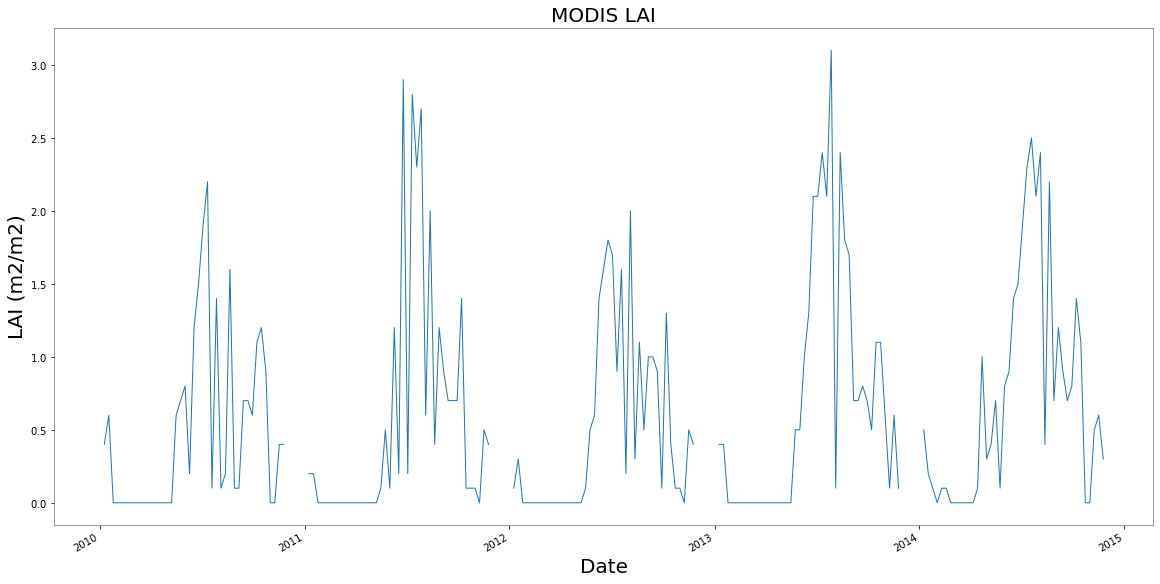

In [112]:
#### Plot the spectra
fig = pl.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
output.where(output<12).plot(ax=ax, kind='line')
ax.get_legend().remove()
ax.set_title('MODIS LAI', size=20)
ax.set_xlabel('Date', size=20)
ax.set_ylabel('LAI (m2/m2)', size=20)
